In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import torch 
from torchvision import datasets, transforms

## Classificação

Vamos usar como exemplo o dataset MNIST de dígitos escritos a mão. É um excelente dataset para quem está aprendendo técnicas de reconhecimento de padrões em imagens, como descreve o próprio autor:<br>
http://yann.lecun.com/exdb/mnist/

O MNIST possui **10 classes**, os dígitos entre 0 e 9, como apresentado na imagem a seguir.

![](https://learnmachinelearning.files.wordpress.com/2017/08/mnist.png)

Ele faz parte dos datasets disponíveis através da biblioteca ```torchvision```<br>
https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST

Na padronização do Torchvision, podemos carregar o dataset com uma simples chamada de função. Cada elemento do MNIST é representado na forma ```(dado, rótulo)```. 

In [ ]:
MNIST = datasets.MNIST('./',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())


dado, rotulo = MNIST[0]
print(type(dado), type(rotulo))

# Channel First: Padrão do torch
print(dado.size()) # C x H x W

<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])


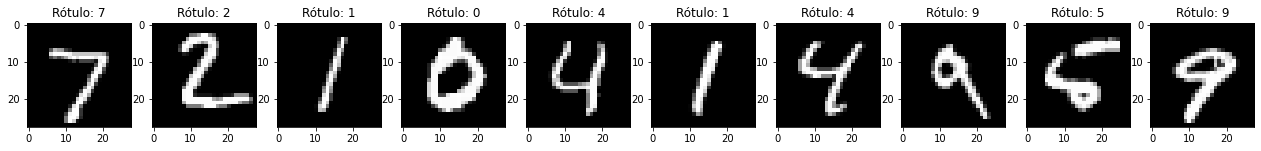

In [ ]:
fig, axs = plt.subplots(1,10, figsize=(22, 4))
for i in range(10):
  dado, rotulo = MNIST[i]
  axs[i].imshow(dado[0], cmap='gray')
  axs[i].set_title('Rótulo: ' + str(rotulo))
plt.show()

> **Como deve ser a última camada de uma rede cujo objetivo é classificar os dados do MNIST?**
---



## Detecção

Para ilustrar o problema de detecção, usaremos o dataset PascalVOC 2012:<br> 
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/


O [PASCAL Visual Object Classes](http://host.robots.ox.ac.uk/pascal/VOC/) é um projeto que realiza competições para desenvolvedores que se interessam pelos desafios do reconhecimento de padrões em imagens. Dentre os desafios estão: detecção, segmentação, reconhecimento de ações, entre outros. <br>


Os dados de detecção podem ser encontrado no pacote Torchvision:<br>
https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection

In [ ]:
coco = datasets.VOCDetection('./', 
                             image_set='train', 
                             download=True, 
                             transform=transforms.ToTensor())

dado, rotulo = coco[0]
print(type(dado), type(rotulo))

<class 'torch.Tensor'> <class 'dict'>


Imagens coloridas possuem **canais** de cor (RGB: *red, green blue*). <br>
Por padrão o PyTorch adota o formato *channel first*, ou seja **canal primeiro**, fazendo referência à dimensionalidade da imagem: **$C \times H \times W$**<br>

Já bilbiotecas de visualização, como o matplotlib, representam as imagens com o canal na última dimensão, por isso antes de plotar a imagem, precisamos organizar as dimensões. 

Dimensionalidade: torch.Size([442, 500, 3])


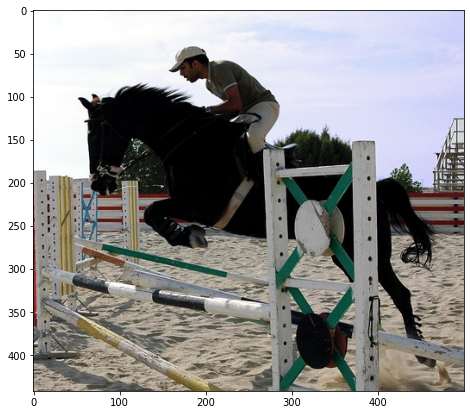

In [ ]:
print('Dimensionalidade:', dado.size())
dado, rotulo = coco[0]
dado = dado.permute(1, 2, 0)

plt.figure(figsize=(8, 7) )
plt.imshow(dado)
plt.show()

In [ ]:
rotulo

{'annotation': {'filename': '2008_000008.jpg',
  'folder': 'VOC2012',
  'object': [{'bndbox': {'xmax': '471',
     'xmin': '53',
     'ymax': '420',
     'ymin': '87'},
    'difficult': '0',
    'name': 'horse',
    'occluded': '1',
    'pose': 'Left',
    'truncated': '0'},
   {'bndbox': {'xmax': '289', 'xmin': '158', 'ymax': '167', 'ymin': '44'},
    'difficult': '0',
    'name': 'person',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '1'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '442', 'width': '500'},
  'source': {'annotation': 'PASCAL VOC2008',
   'database': 'The VOC2008 Database',
   'image': 'flickr'}}}

Estamos interessados no **bounding box** do rótulo, que numa tradução livre seria a "caixa delimitadora", um retângulo que define a localização do objeto na imagem. De acordo com o padrão de anotação do PascalVOC, o rótulo de um objeto pode ser acessado da seguinte forma:
```python
xmax, xmin, ymax, ymin = rotulo['annotation']['object'][0]['bndbox'].values()
```

Para visualizar o bounding box, usaremos os ```patches``` do matplotlib
```
rect = patches.Rectangle((xmin, ymin),w,h)
```

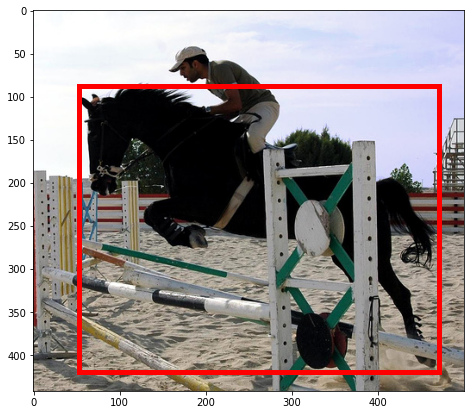

In [ ]:
bbox = rotulo['annotation']['object'][0]['bndbox']
xmax = int(bbox['xmax']) 
xmin = int(bbox['xmin']) 
ymax = int(bbox['ymax'])
ymin = int(bbox['ymin'])

fig, ax = plt.subplots(figsize=(8, 7))
plt.imshow(dado)

rect = patches.Rectangle((xmin, ymin), xmax-xmin , ymax-ymin, fill=False, linewidth=5, edgecolor='r')
ax.add_patch(rect)

plt.show()

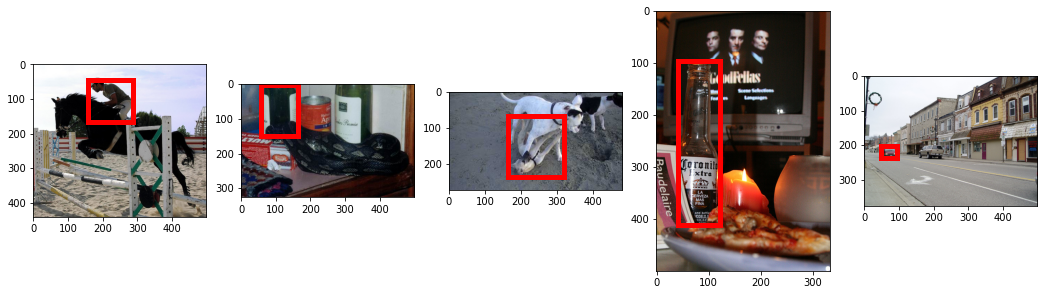

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 7))
for i in range(5):
  dado, rotulo = coco[i]
  dado = dado.permute(1, 2, 0)

  bbox = rotulo['annotation']['object'][1]['bndbox']
  xmax = int(bbox['xmax']) 
  xmin = int(bbox['xmin']) 
  ymax = int(bbox['ymax'])
  ymin = int(bbox['ymin'])

  axs[i].imshow(dado)

  rect = patches.Rectangle((xmin, ymin), xmax-xmin , ymax-ymin, fill=False, linewidth=5, edgecolor='r')
  axs[i].add_patch(rect)

> **Como deve ser a última camada de uma rede cujo objetivo é detectar os objetos do PascalVOC?** <br>
---

## Segmentação

O PascalVOC também fornece rótulos de segmentação para algumas de suas imagens, então continuaremos utilizando este dataset. <br>
https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCSegmentation

A tarefa de segmentação consiste em uma **rotulação densa**, prevendo a localização exata dos objetos na cena a nível de píxel. A imagem a seguir apresenta ambos os rótulos de detecção e segmentação para esclarecer a diferença. 

![](https://www.researchgate.net/profile/Yizhou_Yu/publication/323410937/figure/fig5/AS:644201683361796@1530601058684/The-detection-and-semantic-segmentation-results-on-Pascal-VOC-2012-test-set-the-first_W640.jpg)

Os rótulos de segmentação em geral também são imagens, representando a máscara sobre o objeto que se deseja segmentar.

In [ ]:
coco = datasets.VOCSegmentation('./', 
                             image_set='train', 
                             download=False, 
                             transform=transforms.ToTensor(),
                             target_transform=transforms.ToTensor())

dado, rotulo = coco[0]
print(type(dado), type(rotulo))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
print(dado.size(), rotulo.size())

torch.Size([3, 281, 500]) torch.Size([1, 281, 500])


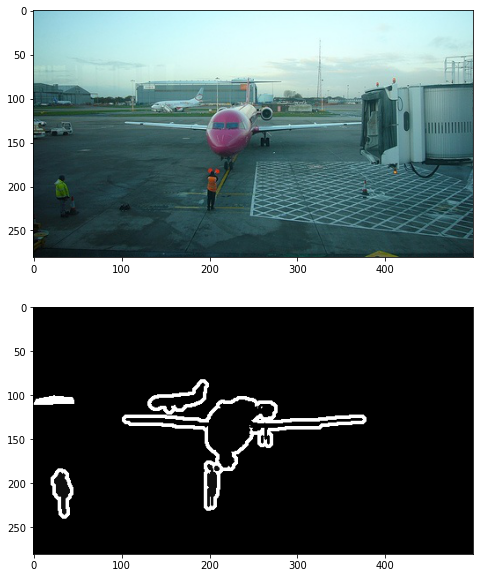

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10, 10))
# dado = dado.permute(1, 2, 0)

axs[0].imshow(dado)
axs[1].imshow(rotulo[0], cmap='gray')

> Em geral, as abordagens de segmentação baseada em Redes Neurais não utilizam camadas totalmente conectadas, em vez disso utilizando arquiteturas **totalmente convolucionais**. Até o final do curso, entenderemos melhor os benefícios disso.